In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.optimize as sci_opt
import yfinance as yf

import sys
import os
print(os.chdir("/home/am_yss/python/portfolio_optimizer_project/"))

print(os.getcwd())

None
/home/am_yss/python/portfolio_optimizer_project


In [ ]:
from backend.data_grab import DataFetcher


tickers = ["2222.SR", "AMD",
              "NVDA", "MSFT",
              "TSLA", "7010.SR",
              "1150.SR", "5110.SR",
              ]

fetcher = DataFetcher(tickers = tickers, years = 15, endDate=dt.datetime.now())

df = fetcher.fetch_data()

df.head()

Exception ignored from cffi callback <function buffer_callback at 0x7f086dfd9f80>:
Traceback (most recent call last):
  File "/home/am_yss/my_project/lib/python3.12/site-packages/curl_cffi/curl.py", line 63, in buffer_callback
    @ffi.def_extern()
    
KeyboardInterrupt: 
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [20]:
end_date = dt.datetime.now()


asset_data = yf.download(tickers = ["AAPL", "MSFT",
                       "7010.SR", "2221.SR",
                       "AMD", "TSLA"], start = (end_date - dt.timedelta(days = 365 * 15)) , end=end_date)

[*********************100%***********************]  6 of 6 completed

1 Failed download:
['2221.SR']: YFTzMissingError('possibly delisted; no timezone found')


In [28]:
asset_tickers = ["AAPL", "MSFT",
                       "7010.SR", "2222.SR",
                       "AMD", "TSLA"]

ticker_df = pd.DataFrame()

for ticker in asset_tickers:
    data = yf.download(tickers = ticker, end = end_date, start = (end_date - dt.timedelta(days = 365 * 15)), auto_adjust=False)
    ticker_df[ticker] = data["Adj Close"]


display(ticker_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,MSFT,7010.SR,2222.SR,AMD,TSLA
Date,,,,,,
2010-05-13,7.774983,22.071995,8.288301,NaN,9.42,NaN
2010-05-14,7.638356,21.837988,NaN,NaN,8.80,NaN
2010-05-17,7.650397,21.845535,8.124987,NaN,8.85,NaN
2010-05-18,7.594422,21.686296,8.104572,NaN,8.42,NaN
2010-05-19,7.473444,21.413319,8.145400,NaN,8.47,NaN


In [33]:
ticker_df[ticker_df["2222.SR"].notna()]



,AAPL,MSFT,7010.SR,2222.SR,AMD,TSLA
Date,,,,,,
2019-12-11,65.554611,144.808472,31.210991,24.817598,39.470001,23.513332
2019-12-12,65.721657,146.278503,30.740473,25.945665,42.590000,23.978666
2019-12-16,67.755341,148.464478,31.085512,26.791721,42.349998,25.433332
2019-12-17,67.888512,147.662659,31.744238,26.615463,42.770000,25.266001
2019-12-18,67.726295,147.357193,31.806980,25.875160,42.299999,26.209999
...,...,...,...,...,...,...
2025-05-01,213.320007,425.399994,46.450001,25.200001,96.650002,280.519989
2025-05-05,198.889999,436.170013,46.200001,24.900000,100.589996,280.260010
2025-05-06,198.509995,433.309998,46.000000,24.980000,98.620003,275.350006


In [7]:
risk_df = fetcher._fetch_treasury()

risk_df

,value
Date,
2005-03-29,4.60
2005-03-30,4.56
2005-03-31,4.50
2005-04-01,4.46
2005-04-04,4.47
...,...
2025-03-14,4.31
2025-03-17,4.31
2025-03-18,4.29


In [8]:
#calculate the daily log returns for each ticker in the dataframe
log_returns  = np.log1p(df.pct_change())
n_tickers = len(tickers)

log_returns = log_returns.iloc[1:]

#randomize the weights for each ticker
randomized_weights = np.array(np.random.random(n_tickers))



In [9]:
n_tickers * [1./n_tickers]

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [10]:
#rebalance the weight so that they all add up to 1
weights_rebal = randomized_weights / sum(randomized_weights)

#ensure that they all add up to one
print(weights_rebal.sum())

print(weights_rebal)

1.0
[0.04515011 0.12230635 0.12219654 0.13488685 0.02461456 0.07047192
 0.09946579 0.16335339 0.0775778  0.1399767 ]


In [11]:
#calculate the expected returns annually
sims = 10000
weights_array = np.zeros((sims, n_tickers))
returns_array = np.zeros(sims)
volatility_array = np.zeros(sims)
sharpe_array = np.zeros(sims)

for index in range(sims):

    log_returns = np.log1p(df.pct_change())

    weights = np.array(np.random.random(n_tickers))

    weights = weights/sum(weights)

    weights_array[index, :] = weights

    returns_array[index]  = np.sum(log_returns.mean() * weights) * 252 # active trading days (rolling 252 days)

    volatility_array[index] = np.sqrt(

        np.dot(
            weights.T,
            np.dot(
                log_returns.cov() * 252,
                weights
            )
        )
    )

    sharpe_array[index] = (returns_array[index] - 0.01)/volatility_array[index]



weight_columns = [f"Weight_{i}" for i in range(n_tickers)]
simulations = pd.DataFrame({"Expected Returns" : returns_array,
                            "Volatility": volatility_array,
                            "Sharpe Ratio": sharpe_array,
                            **{col:weights_array[:, i] for (i, col) in enumerate(weight_columns)}
    
})



simulations.head()

,Expected Returns,Volatility,Sharpe Ratio,Weight_0,Weight_1,Weight_2,Weight_3,Weight_4,Weight_5,Weight_6,Weight_7,Weight_8,Weight_9
0,0.082433,0.176946,0.409349,0.106848,0.053313,0.071604,0.106059,0.050736,0.086446,0.139703,0.133315,0.108541,0.143436
1,0.108197,0.181646,0.540595,0.017925,0.130769,0.046640,0.072896,0.199380,0.112146,0.165193,0.169128,0.025686,0.060236
2,0.096548,0.168219,0.514493,0.070002,0.202650,0.041016,0.039224,0.270442,0.016817,0.125061,0.116907,0.041169,0.076713
3,0.063639,0.177283,0.302564,0.100423,0.031569,0.195885,0.029746,0.083800,0.044552,0.176821,0.121601,0.020593,0.195011
4,0.098020,0.183260,0.480300,0.057360,0.141799,0.134916,0.146431,0.072637,0.091646,0.139808,0.089024,0.111764,0.014614


In [9]:
cols_rename = {}

for i, ticker in enumerate(tickers):
    cols_rename[f"Weight_{i}"] = ticker

simulations = simulations.rename(cols_rename, axis = 1)

simulations.columns

Index(['Expected Returns', 'Volatility', 'Sharpe Ratio', '2222.SR', '1120.SR',
       '1180.SR', '2010.SR', '7010.SR', '1211.SR', '1010.SR', '1140.SR',
       '1150.SR', '5110.SR'],
      dtype='object')

In [1]:
max_sharpe = simulations.iloc[simulations["Sharpe Ratio"].idxmax()]
least_risk = simulations.iloc[simulations["Volatility"].idxmin()]


NameError: name 'simulations' is not defined

/tmp/ipykernel_24654/368931660.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_24654/368931660.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe[1],
/tmp/ipykernel_24654/368931660.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe[0],
/tmp/ipykernel_24654/368931660.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

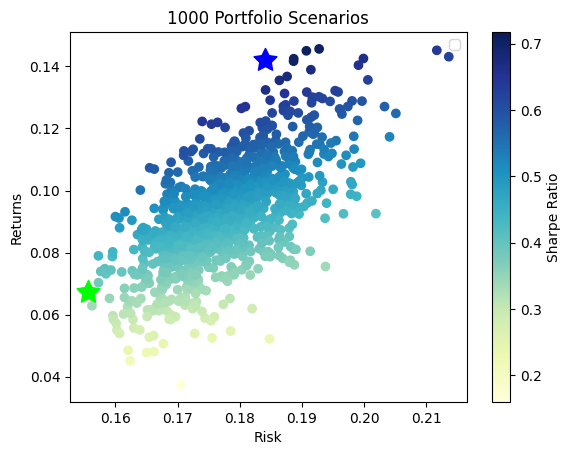

In [20]:
%matplotlib inline

plt.scatter(y = simulations['Expected Returns'],
            x = simulations['Volatility'],
            c = simulations['Sharpe Ratio'],
            cmap = 'YlGnBu')

plt.title("1000 Portfolio Scenarios")
plt.xlabel("Risk")
plt.ylabel("Returns")
plt.colorbar(label = "Sharpe Ratio")
plt.legend()

#plot the max sharpe ratio
plt.scatter(
    max_sharpe[1],
    max_sharpe[0],
    marker = (5,1,0),
    color = "blue",
    s = 300
)


plt.scatter(
    x = least_risk[1],
    y = least_risk[0],
    marker = (5,1,0),
    color = "lime",
    s = 300
)


plt.show()
